# Patch Discord
## The Aleatoric MIDI Router

### Introduction

The aletoric MIDI router is a device that serves the purpose of erasing the labels from the control knobs of a synthesizer.

In a system comprising a controller and a synthesizer, the router can be placed in the middle, receiving a number of control signals and outputting altered control signals. As can be guessed from the name, the router randomly permutes signal destinations. However, it does not simply route its inputs to different channels. This would have resulted in simply renaming the knobs, and not yet erasing their labels. Instead, the router performs a permutation such that *all* the input channels affect *all* the output channels. This way, a musician using a controller cannot know what the result of a turn of a knob would be, and thus cannot apply his or her knowledge and experience, but has to completely rely on listening instead. Furthermore, to exclude the possibility of the musician getting accustomed to the routing with time and mentally mapping the controls to their new destinations, the internal state of the router gradually changes, so that the routing is never static. The output changes even when the musician does not provide any input. This side effect serves as an invitation for the musician to actively work even when just maintaining a certain timbre.

The aleatoric router is clearly not a utility device, but rather a catalyst of a creative practice.

### Notes on implementation

While the general description above does not imply a single implementation, this document develops one possible implementation of the router.

The router can be realised as a MIDI effect plugin for DAWs, as well as a standalone hardware device. Moreover, an analog variant is also concievable, replacing MIDI with CV signals. However, the current implementation focuses on MIDI.

### High-level structure

In a setup with a separate controller and a sound engine, the router fits in the middle:

```
+---+          +---+           +---+
| C | == M ==> | R |  == M ==> | S |
+---+          +---+           +---+

C - controller
M - MIDI bus
R - router
S - synth
```

---

The internal structure of the router is demonstated by the figure below:

```
     ⎡ ⎤    ⎡   ⎤    ⎡ ⎤
M ==>⎢I⎢ -> ⎢ P ⎢ -> ⎢O⎢ ==> M
     ⎣ ⎦    ⎣   ⎦    ⎣ ⎦
                ^
                ^
                G
               
M - MIDI bus
I - input accumulator
P - permutation
G - internal state generator
O - output accumulator
```

---

The principal operation performed by the router is a permutation of an input vector (permutation here is not to be understood in its combinatorial meaning). To adapt to the event-driven model of the MIDI protocol, input and output accumulators are employed. The input accumulator receives MIDI CC events and outputs a vector of the latest values on each of the preconfigured channels. The output accumulator perfoms the reverse operation: it receives the result of the permutation and emits MIDI CC events on channels on which the value has changed.

One cycle of the router's operation consists of:
1. freezing the input vector
2. performing a permutation
3. sending to the bus the difference between the permutation result and the previous cycle's output

As has been already mentioned, the permutation is not static. The purpose of the internal state generator is to periodically generate the permutation parameters. The state generator is not clocked at the same rate as the main cycle.

The clock rate of the main cycle should be approximately the rate at which the knobs are scanned by the controller, so that CC events are not missed, otherwise the user will experience unresponsiveness.

The clock rate of the state generator should be substantially slower, otherwise something akin to a frantic LFO on all the configured channels will be heard. In general, the state change rate should be a user-controllable parameter.

### Permutation

The main operation of the router is the permutation of an input vector. The term permutation here is not used in its combinatorial meaning, but is defined below instead.

First of all, it should be pointed out that all the values on the MIDI bus are taken to be integers in the range $[0; 127]$. The input and the output of the permutation are vectors of values in this domain.

The term channel is used below to signify a MIDI CC number. In more conventional MIDI terminology, the router operates on a single MIDI channel, but on multiple controllers (aka CC).

Before the permutation is derived, its desired characteristics should be clarified.
1. Number of input and output channels need not necessarily be equal.
2. All the input channels affect all the output channels to a certain degree.
3. The mapping should be continuous (in the discreet approximation, as we are operating in integers), so that close input vectors map to close output vectors.
4. The mapping should **not** be intuitively understandable by the musician. This implies that a permutation that maps all-zero input to all-zero output and/or all-maximum input to all-maximum output is unsatisfactory.
5. The output vector should not overflow.
6. The full range of each output channel should be covered by the input space. In other words, for each output channel for each possible value there exists at least one input vector that maps to an output vector that contains this value.
7. The state of the permutation should be gradually variable. This means that the permutation is parameterised, and changing the permutation parameter results in smooth changes in the output given the same input.

It should also be noted that the following properties are not specifically aimed for:
- Covering the entire output space is not required. Any specific output vector it is not guaranteed to be reachable.
- Unique mapping is not required. For any reachable output vector there might exist more than one input vector that maps to it.

All these requirements do not describe a single possible permutation. In the context of the musical device, a precise mathematical destination is probably not relevant. One permutation that fulfills the requirements is derived below, using some basic linear algebra and some intuitions.

To satisfy the first requirement, let's immediately consider the general case of $n$ input channels and $m$ output channels. The task is now to find a mapping from $n$ dimensional vector space to $m$ dimensional vector space.

\begin{equation}
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}
\mapsto
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

We begin with a linear mapping and introduce a matrix $P$ with $m$ rows and $n$ columns.  This satisfies the second requirement, as the element $p_{mn}$ of the matrix is a weigth with which $n$-th input contributes to $m$-th output.

\begin{equation}
\begin{bmatrix}p_{11} & p_{12} & ... & p_{1n} \\ p_{21} & ... \\ ... & & ... \\ p_{m1} & & & p_{mn}\end{bmatrix}
\times
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}=
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

Linear mapping also satisfies the third requirement: there are no abrupt jumps in output.

However, the fourth requirement, namely that the all-zero input should not map to all-zero output renders a linear mapping unsatisfactory. The fourth requirement calls for a translation. Let's introduce a translation vector that is added to the input vector before the multiplication by the matrix.

\begin{equation}
\begin{bmatrix}p_{11} & p_{12} & ... & p_{1n} \\ p_{21} & ... \\ ... & & ... \\ p_{m1} & & & p_{mn}\end{bmatrix}
\times
\left(
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}
+
\begin{bmatrix}t_{1} \\ t_{2} \\ ... \\ t_{n}\end{bmatrix}
\right)=
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

The fifth requirement is that the output doesn't overflow. Let's consider each output channel separately. The value of the $k$-th output channel is defined by the input vector and the $k$-th row of the matrix.

\begin{equation}
o_{k} = p_{k1} (i_{1} + t_{k}) + p_{k2} (i_{2} + t_{k}) + ... + p_{kn} (i_{n} + t_{k})
\end{equation}

By carefully picking the $p$ coeffiecients, it can be ensured that the output doesn't overflow. For example, if we ignore the translation, we can achieve that by choosing coefficients to be in the range of $[0; 1]$ in such a way that the sum of the row is $1$. Then each coefficient is the percentage of contribution of the corresponding input.

This is a viable solution. However, in this case  every input channel affects any output channel only to a limited degree. No input channel can reach the full range of an output channel.

It appears that in order to be more musically interesting, the control should be more redundant. Some input channels should be able to reach the full range of output, and some other input channels should be able to reverse the effect of the former channels.

So the internal calculations are performed in a broader domain. The translation and multiplication results are allowed to overflow the MIDI range. The multiplication product is mapped back to the domain afterwards.

\begin{equation}
wrap
\left(
\begin{bmatrix}p_{11} & p_{12} & ... & p_{1n} \\ p_{21} & ... \\ ... & & ... \\ p_{m1} & & & p_{mn}\end{bmatrix}
\times
\left(
\begin{bmatrix}i_{1} \\ i_{2} \\ ... \\ i_{n}\end{bmatrix}
+
\begin{bmatrix}t_{1} \\ t_{2} \\ ... \\ t_{n}\end{bmatrix}
\right)
\right)=
\begin{bmatrix}o_{1} \\ o_{2} \\ ... \\ o_{m}\end{bmatrix}
\end{equation}

We need to employ such a way of wrapping that respects the continuity requirement. Wrapping using a modulo operation does not fulfill this requirment, as it involves a jump from one boundary to the other:

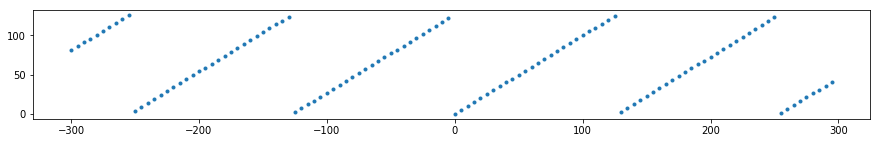

In [5]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-300, 300, 5)
y = x % 127

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, '.')
plt.show()

Instead of making a jump, the value could bounce from the boundary and start moving in the opposite direction:

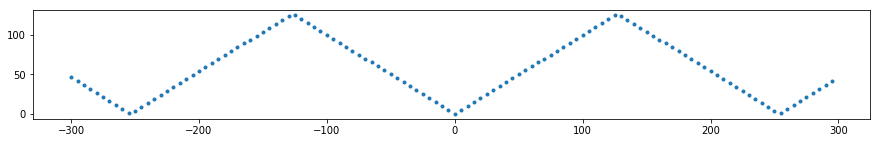

In [2]:
def wrap(x, limit):
    '''The lower limit is assumed to be 0.'''
    x %= 2 * limit
    if x > limit:
        x = 2 * limit - x
    return x

y = np.array([wrap(xi, 127) for xi in x])

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(x, y, '.')
plt.show()

Wrapping is applied to each element of the output vector.

With wrapping, the elements of the matrix can be picked almost arbitrarily.

However, it is desirable that input covers the output range more than once. The value of a coefficient can be understood as the number of times an input channel covers an output channel (ignoring translation). Large values of coefficients decrease the resolution of the input controls, which is to be avoided. Intuitively, the values of the coefficients should remain approximately  in the range $[-2, 2]$, where negative coefficients mean inversion of the input channel.

Also by intuition, the elements of the translation vector are in the MIDI domain.

The remaining requirement is that the permutation should be parameterized. This is detailed in the next section.

### Internal State

The internal state of the router comprises the translation vector and the matrix. The state should be gradually variable, so that varying the state does not result in jumps in the output.

The translation vector can be randomly chosen at the inititialization time and fixed from then on.

The matrix should be periodically regenerated, and the next matrix should be closely related to the previous matrix. The elements of the matrix should be in the range $[-2; 2]$. A parameterized function that always yields values within a certain range is necessary.

A simple example of such a function is the sine function:
\begin{equation}
x = a \cdot sin{(f t + \phi)} + c
\end{equation}

Since the range is symmetrical with respect to $0$, the constant $c$ is $0$.

$a$ is the scaling factor controlling the output range. It should be set to $2$.

Each row of coefficients can be picked as samples from a section of a sine wave one period long.
The equation for the elements of a row is:

\begin{equation}
p_{i} = 2 \cdot sin{((i - 1) \frac{2 \pi}{n} + \phi)}
\end{equation}

$n$ is the number of coefficients, which is the number of inputs. $i$ is the index of the element in the row, in the range $[1; n]$.

This way there is one peak and one valley per row, that is per output channel. This translates to one input channel being the dominant control, and another input channel being its opposite.

The phase $\phi$ is the variable parameter of the permutation. As it changes, the row of coefficients slightly shifts along the sine wave, but never changes abruptly. Initial phases per row can be randomly chosen at initialization time, just like the translation vector.

$\phi$ is gradually incremented. The rate of change of $\phi$ is the rate of the state generator mentioned in the section on high-level structure. The precise value can be user-controlled, but the full cycle (change of $\phi$ by $2\pi$ radians) should take several minutes, so that the fact that the state is periodic is not obvious to the user.

Here is a demonstration of sampling of the coefficients:

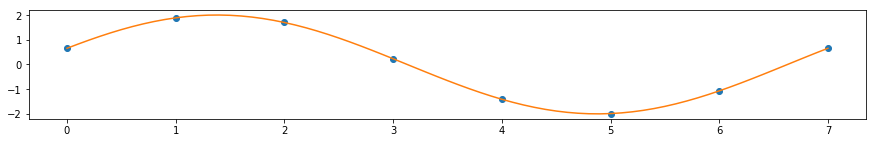

In [3]:
import matplotlib.pyplot as plt
import numpy as np

PHI = .333
N = 8 # number of coefficients

def coefficient(index):
    return 2 * np.sin((index * 2 * np.pi) / (N - 1) + PHI)

indices = [i for i in range(N)]
samples = np.array([coefficient(i) for i in indices])

# detailed function for demonstration
ref_x = np.arange(0, N - 0.9, 0.1)
ref_y = np.array([coefficient(i) for i in ref_x])

fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(indices, samples, 'o', ref_x, ref_y, '-')
plt.show()

There is one more consideration. With the coefficients sampled from a sine wave, the user might notice a spatial pattern of the dominant control and the opposite control being $n/2$ knobs apart if there are $n$ inputs. In order to conceal this spatial pattern, one more step is added. After the coefficients are sampled, they are shuffled, so that they appear in the matrix in a different order.

The shuffling can be represented with a shuffling matrix $S$ that has the same dimensions as the permutation matrix. The element of each row of the shuffling matrix $s_{i}$ represents the column in the permutation matrix to which the $i$-th sample from the sine wave will go. So the rows of the permutation matrix are shufflings of numbers from 1 to $n$, where $n$ is the number of coefficients.

In [4]:
import random

shuffling = random.sample(indices, len(indices))
    
coefficients = [0 for i in range(N)]
for i in indices:
    coefficients[i] = samples[shuffling[i]]

print("shuffling:")
print("\n".join(["from {0} to {1}".format(i, v) for i, v in enumerate(shuffling)]))
print("\nsamples:")
print(" | ".join(["{:.3f}".format(i) for i in samples]))
print("\ncoefficients:")
print(" | ".join(["{:.3f}".format(i) for i in coefficients]))

shuffling:
from 0 to 7
from 1 to 0
from 2 to 1
from 3 to 5
from 4 to 4
from 5 to 3
from 6 to 2
from 7 to 6

samples:
0.654 | 1.885 | 1.697 | 0.231 | -1.409 | -1.988 | -1.070 | 0.654

coefficients:
0.654 | 0.654 | 1.885 | -1.988 | -1.409 | 0.231 | 1.697 | -1.070


Finally, the full state of the router is represented by:
- translation vector
- initial phases vector
- shuffling matrix
- current phase shift

All of these except for the phase shift are fixed at the initialization stage.
The phase shift is incremented at state change rate. The permutation matrix is then regenerated with the new phase shift.